# Tarea 1 <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Martín Cornejo Saavedra
Fecha para completar la tarea: miercoles 25 de abril de 2018


## Insturcciones:
En este notebook debes dejar todo tu código de las partes 1 hasta 8 de la tarea. Debes dejar el código (y todo lo adicional que hayas programado) en las celdas designadas para ello. Las partes que se hacen a mano (o con fórmulas), puedes entregarlas al final o en un archivo separado. En la siguiente celda encontrarás un *check list* de las partes de la tarea. En cada item indica si lo completaste o no en tu entrega ('SI', o 'NO'). Por favor, no marques como 'SI' partes que no hiciste. Adicionalemnte, el lugar en tu código donde completaste cada parte, márcala con un comentario como el siguiente

```
#### Parte 4a) Método backward
```

Si bien para algunas partes puede no estar exactamente claro dónde comienza (y termina) cada parte, usa tu criterio para los comentarios. Esto es sólo para ayudarnos a corregir. Nota que las celdas de más abajo no necesariamente siguen el orden del check list. Por ejemplo en la celda donde defines tu clase para la red neuronal se espera agregues código de las partes 2, 3, 7 etc. Todo eso está en una única celda (lo entenderás cuando mires más abajo).

Por favor sigue este formato. **Si no sigues el formato te descontaremos puntaje.**

---

## Checklist

Parte|Completado
---:|---:
**1) Activación, derivadas, y salida** |
1a) Funciones de activación | SI
1b) Derivando las funciones de activación | SI
1c) Softmax | SI
**2) Red neuronal y pasada hacia adelante** |
2a) Clase para red neuronal | SI (solo 2 capas fijas, falta hacerlo para N capas)
2b) Usando la GPU | SI
2c) Pasada hacia adelante | SI
2d) Probando tu red con un modelo pre-entrenado | SI (falta accurracy)
**3) Más derivadas y backpropagation** |
3a) Entropía cruzada | SI
3b) Derivando la última capa | SI (falta desarrollo de derivar softmax)
3c) Derivando desde las capas escondidas | SI (falta derivar celu, relu, etc..)
**4) Backpropagation en nuestra red** |
4a) Método backward | SI (falta hacerlo para N capas)
4b) Checkeo de gradiente | NO
4c) Opcional: incluyendo los parámetros de celu y swish | NO
**5) Descenso de gradiente y entrenamiento** |
5a) Descenso de gradiente | SI
5b) Datos para carga | SI
5c) Entrenando la red | SI
5d) Graficando la pérdida en el tiempo | SI
5e) Entrenando con datos no random | NO
**6) Regularización** |
6a) Regularización por penalización de norma | Falta implementar el nuevo loss, para eso falta red de capa dinamica
6b) Regularización por dropout | NO
**7) Optimización** |
7a) Inicialización de Xavier | NO
7b) Descenso de gradiente con momentum | NO
7c) RMSProp | NO
7d) Adam | NO
7e) Opcional: batch normalization | NO
**8) Entrenando sobre MNIST** |
8a) Cargando y visualizando datos de MNIST | NO
8b) Red neuronal para MNIST | NO
8c) Opcional: visualización de entrenamiento y convergencia | NO

---

In [0]:
# Este notebook está pensado para correr en CoLaboratory. 
# Comenzamos instalando las librerías necesarias.
# Si lo estás ejecutando localmente posiblemente no sea necesario
# reinstalar todo.

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
!pip install -q ipdb

import os
import glob
import torch
import numpy
import pdb
import matplotlib.pyplot as plt

# Agrega acá todo lo que quieras importar o instalar

## Funciones de activación, predicción y pérdida

In [0]:
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

In [0]:
#### Parte 1a) Funciones de activación

def relu(T):
    T[T < 0] = 0
    return T

def swish(T, beta):
    return torch.mul(T, sig(torch.mul(T, beta)))

def celu(T, alfa):
    positive = relu(T)
    negative = torch.mul(relu(torch.mul(T, -1)), -1)
    celu_T = torch.mul(torch.add(torch.exp(torch.div(negative, alfa)), -1), alfa)

    return torch.add(positive, 1, celu_T)

In [0]:
#### Parte 1c) Softmax está implementada solo para tensores en 2-D
def softmax(T, dim=0, estable=True):
    denom_softmax = torch.div(T, 2)
    denom_softmax = torch.exp(denom_softmax)
    denom_softmax = torch.mm(denom_softmax, torch.transpose(denom_softmax, 0, 1))
    denom_softmax = torch.reciprocal(torch.diag(denom_softmax))

    return torch.mm(torch.diag(denom_softmax), T.exp())

In [0]:
#### Parte 3a) Entropía cruzada
def cross_ent_loss(Q,P):
    dimension = 0
    q_log = torch.log(Q)
    product = torch.mul(P, torch.reciprocal(q_log))

    return -torch.sum(product)/Q.size(dimension)

## Clase FFNN, incialización, forward, backward y regularización


In [0]:
#### Parte 2a) Clase para red neuronal
class FFNN():
  
  def __init__(
  #    self, F, l_h, l_a, C, 
  #    wc_par=None, 
  #    keep_prob=None, 
  #    init=None,
  #    bn=None
  #):
    self, F, l_h, l_a, C, params=[],
    wc_par=None,
    keep_prob=[]
  ):
      if (len(params) > 0):
        W_1 = params[0][0]
        b_1 = params[0][1]
        W_2 = params[1][0]
        b_2 = params[1][1]
        U = params[2][0]
        c_init = params[2][1]
        
        c_init = c_init.view(1, c_init.size(0))
        b_2 = b_2.view(1, b_2.size(0))
        b_1 = b_1.view(1, b_1.size(0))
        
        self.l_a = l_a
        self.parametros = [(W_1, b_1), (W_2, b_2), (U, c_init)]

      else:
        self.F = F
        l_h.append(C)
        self.l_h = l_h
        self.l_a = l_a
        self.C = C

        self.parametros = []

        for idx, neuronas in enumerate(self.l_h):
          if (idx == 0):
            pesos = torch.randn(F, neuronas)
          else:
            pesos = torch.randn(self.l_h[idx-1], neuronas)

          bias = torch.randn(1, neuronas)
          self.parametros.append((pesos, bias))
        
      self.wc_par = wc_par        
      self.keep_prob = keep_prob
        
        
  #### Parte 2b) Usando la GPU
  
  def toDouble(self):
    for idx, param in enumerate(self.parametros):     
        self.parametros[idx] = (param[0].double(), param[1].double())
  
  def gpu(self):
    if torch.cuda.is_available():
      for idx, param in enumerate(self.parametros):
        self.parametros[idx] = (param[0].cuda(), param[1].cuda())
  
  def cpu(self):
    for idx, param in enumerate(self.parametros):
        self.parametros[idx] = (param[0].cpu(), param[1].cpu())
    
    #### Parte 7a) Inicialización de Xavier
    #### Parte 7e) Opcional: batch normalization
    
  
  #### Parte 2c) Pasada hacia adelante
  def forward(self, x, predict=False):
    self.toDouble()
    x = x.double()
    
    if torch.cuda.is_available():
      x = x.cuda()
      self.gpu()   # redundante, corregir
      
    else:   
      self.cpu()   # redundante, corregir
      
    if (len(self.keep_prob) == 0 or not predict):
      prob_array = torch.ones(3)   # no se apagan neuronas
        
    # iterar para crear las mascaras de bits segun los largos de las matrices,
    # hacerlo dinamico segun el numero de capas
    
    self.h_array = []
    
    for idx, f_activacion in enumerate(self.l_a):
      if (idx == 0):
        self.h_layer = f_activacion(torch.mm(x, self.parametros[idx][0]) + self.parametros[idx][1])
      else:
        self.h_layer = f_activacion(torch.mm(self.h_layer, self.parametros[idx][0]) + self.parametros[idx][1])
      
      self.h_array.append(self.h_layer)

    y = softmax(torch.mm(self.h_layer, self.parametros[len(self.parametros)-1][0]) + self.parametros[len(self.parametros)-1][1])
    self.h_array.append(y)

    return y

  
  #### Parte 4a) Método backward
  def chooseDeriv(self, funcion_activacion):
    if (funcion_activacion == sig):
      return lambda x: torch.mul(x, torch.mul(torch.add(x, -1), -1))
    else:
      raise Exception('Derivada no implementada')
  
  def backward(self,x,y,y_pred):
    nHidden = len(self.l_a)
    gradientes = [0] * (nHidden + 1)
    deriv_activaciones = [0] * (nHidden + 1)

    # gradientes capa de salida
          
    #dL_duL = torch.mul(torch.mul(y, torch.add(y_pred, -1)), 1/y_pred.size(0))
    dL_duL = torch.mul(torch.add(y_pred, torch.mul(y, -1)), 1/y_pred.size(0))
    dL_dU = torch.mm(torch.transpose(self.h_array[nHidden-1], 0, 1), dL_duL)
    dL_dc = torch.mm(torch.ones(1, dL_duL.size(0)).double().cuda(), dL_duL)
    dL_dh2 = torch.mm(dL_duL, torch.transpose(self.parametros[nHidden][0], 0, 1))
      
    assert dL_duL.size() == self.h_array[nHidden].size()
    assert dL_dU.size() == self.parametros[nHidden][0].size()
    assert dL_dc.size(1) == self.parametros[nHidden][1].size(1)
    assert dL_dh2.size() == self.h_array[nHidden-1].size()

    gradientes[nHidden] = (dL_dU, dL_dc)
    deriv_activaciones[nHidden] = dL_dh2

    # gradientes capas escondidas

    for idx, f_activacion in enumerate(self.l_a):

      derivadaActivacion = self.chooseDeriv(self.l_a[nHidden-idx-1])
      
      dL_du_hidden = torch.mul(deriv_activaciones[nHidden-idx], derivadaActivacion(self.h_array[nHidden-idx-1]))

      if (nHidden-1 == idx):
        dL_dW = torch.mm(torch.transpose(x, 0, 1), dL_du_hidden)
      else:
        dL_dW = torch.mm(torch.transpose(self.h_array[nHidden-idx-2], 0, 1), dL_du_hidden)

      dL_db = torch.mm(torch.ones(1, dL_du_hidden.size(0)).double().cuda(), dL_du_hidden)
      dL_dh_n_1 = torch.mm(dL_du_hidden, torch.transpose(self.parametros[nHidden-idx-1][0], 0, 1))

      assert dL_du_hidden.size() == self.h_array[nHidden-idx-1].size()
      assert dL_dW.size() == self.parametros[nHidden-idx-1][0].size()
      assert dL_db.size(1) == self.parametros[nHidden-idx-1][1].size(1)

      if (nHidden-2-idx > -1):   # no comparamos el tamaño de dL/dx, no es relevante
        assert dL_dh_n_1.size() == self.h_array[nHidden-2-idx].size()

      gradientes[nHidden-idx-1] = (dL_dW, dL_db)
      deriv_activaciones[nHidden-idx-1] = dL_dh_n_1
         
    self.gradientes = gradientes
      
      
  def actualizarParams(self, lr):
    
    # mover esto al optimizador, para luego poder calcular los nuevos gradientes usando
    # wc_par   
    
    const = 1
    
    # Parte 6a) agregando weight decay
    if (self.wc_par != None):
      const = const - lr * self.wc_par
    
    for idx in range(len(self.l_a) + 1):
      W_aux = self.parametros[idx][0] * const - lr * self.gradientes[idx][0]
      b_aux = self.parametros[idx][1] * const - lr * self.gradientes[idx][1]

      self.parametros[idx] = (W_aux, b_aux)

## Probando tu red con un modelo pre-entrenado y visualizando casos incorrectos

In [68]:
#### Parte 2d) Probando tu red con un modelo pre-entrenado

## Clonamos el github

#!git clone https://github.com/jorgeperezrojas/cc6204-DeepLearning-DCCUChile.git

os.chdir("/content/cc6204-DeepLearning-DCCUChile/2018/tareas/tarea1/recursos/varita_magica")

# cargar parametros entrenados a tensores

local_download_path = "modelos/ejemplo"
params = []
params.append([numpy.loadtxt(local_download_path+"/W1.txt"), numpy.loadtxt(local_download_path+"/b1.txt")])
params.append([numpy.loadtxt(local_download_path+"/W2.txt"), numpy.loadtxt(local_download_path+"/b2.txt")])
params.append([numpy.loadtxt(local_download_path+"/U.txt"), numpy.loadtxt(local_download_path+"/c.txt")])

params = list(map(lambda x: [torch.from_numpy(x[0]), torch.from_numpy(x[1])], params))
#pdb.set_trace()


# cargar red neuronal en pase a parametros conocidos

test_data_path = "data/test_set"
test_input = torch.from_numpy(numpy.loadtxt(test_data_path+"/hechizo-7/019.txt")).view(1, 4096)
red_neuronal = FFNN(0, [], [sig, sig], 10, params)
red_neuronal.forward(test_input)



Columns 0 to 5 
 4.7710e-02  3.9716e-05  6.6476e-04  8.2011e-10  4.3855e-05  5.6656e-06

Columns 6 to 9 
 3.6484e-06  1.4471e-04  9.5139e-01  3.8229e-08
[torch.cuda.DoubleTensor of size 1x10 (GPU 0)]

El siguiente hechizo pertenece a la clase 9 pero fue clasificado como clase 1:


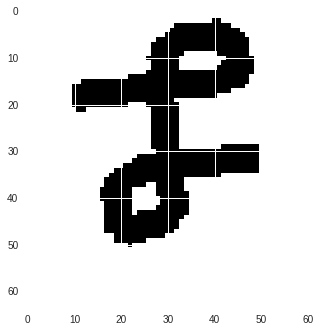

El siguiente hechizo pertenece a la clase 7 pero fue clasificado como clase 8:


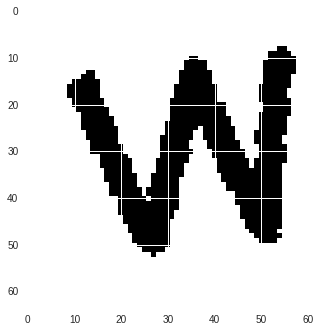

In [8]:
test_input_err_1 = torch.from_numpy(numpy.loadtxt(test_data_path+"/hechizo-9/019.txt")).double().cuda().view(64, 64)
plt.imshow(test_input_err_1)
print("El siguiente hechizo pertenece a la clase 9 pero fue clasificado como clase 1:")
plt.show()
test_input_err_2 = torch.from_numpy(numpy.loadtxt(test_data_path+"/hechizo-7/019.txt")).double().cuda().view(64, 64)
plt.imshow(test_input_err_2)
print("El siguiente hechizo pertenece a la clase 7 pero fue clasificado como clase 8:")

## Checkeo de gradiente

In [0]:
#### Parte 4b) Chequeo de gradiente

## Descenso de gradiente, momentum, RMSProp y Adam


In [0]:
#### Parte 5a) Descenso de gradiente
class SGD():
  def __init__(self, red, lr):
    self.red = red
    self.lr = lr
  
  def step(self):
    self.red.actualizarParams(self.lr)
    
#### Parte 7b) Descenso de gradiente con momentum
class SGD2():
  def __init__(self, red, lr, momentum=0.9):
    pass
  
  def step():
    pass

In [0]:
#### Parte 7c) RMSProp
class RMSProp():
  def __init__(self, red, lr=0.001, beta=0.9, epsilon=1e-8):
    pass
  
  def step():
    pass

In [0]:
#### Parte 7d) Adam
class Adam():
  def __init__(self, red, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    pass
  
  def step():
    pass

## Datos random para carga


In [0]:
#### Parte 5b) Datos para carga
class RandomDataset():
  def __init__(self, N, F, C):
    x = torch.rand(N, F)
    self.x = torch.bernoulli(x).double().cuda()
    self.y = torch.from_numpy(numpy.eye(C)[numpy.random.choice(C, N)]).double().cuda()
    self.large = N
  
  def __len__(self):
    return self.large
  
  def __getitem__(self, i):
    return (self.x[i,:], self.y[i,:])
  
  def paquetes(self, B):
       
    if not hasattr(self, 'arr_paquetes'):
      n_iters = int(self.x.size(0)/B)
      arr_paquetes = []  
   
      for index in range(n_iters):
        arr_paquetes.append(self.elige_batch(self.x,self.y,B))
              
      self.arr_paquetes = arr_paquetes
      
    return self.arr_paquetes
    
  # Para elegir el siguiente batch (uno al azar) desde los datos de entrada
  def elige_batch(self, X, Y, b):
    N = X.size()[0]
    x_lista = []
    y_lista = []
  
    for _ in range(b):
      i = numpy.random.randint(N)
      x_lista.append(X[i:i+1])
      y_lista.append(Y[i:i+1])      
  
    x = torch.cat(x_lista, dim=0)
    y = torch.cat(y_lista, dim=0)
    #pdb.set_trace()
  
    return x,y
    

## Loop de entrenamiento

In [0]:
#### Parte 5c) Entrenando la red
def entrenar_FFNN(red_neuronal, dataset, optimizador, epochs, B):
  
  perdidas = []
  
  for e in range(1,epochs+1):
    for x,y in dataset.paquetes(B):
      y_pred = red_neuronal.forward(x)
      #pdb.set_trace()
      loss = cross_ent_loss(y_pred,y)
      
      #6a) Regularización por penalización de norma
      if (red_neuronal.wc_par != None):
        loss += penalizacionNorma(red_neuronal.params, B)
            
      perdidas.append(loss)
      
      red_neuronal.backward(x, y, y_pred)
      optimizador.step()  
    
  return red_neuronal, perdidas  

def penalizacionNorma(arrayMatrix, B):
  return 0

## Entrenando con datos random y graficando la pérdida

True

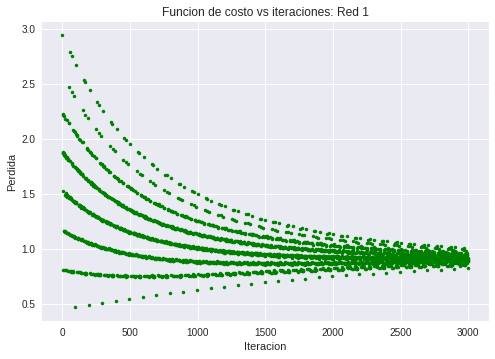

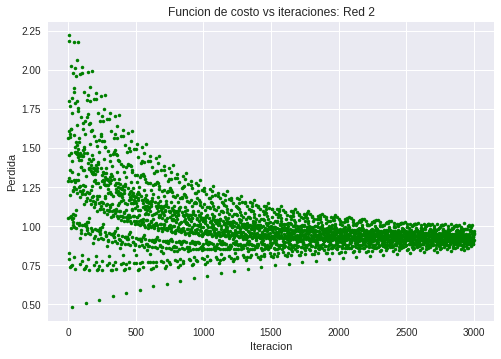

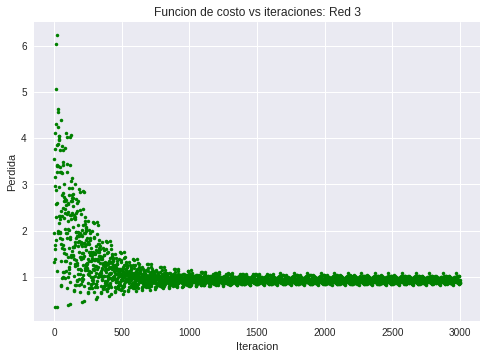

In [93]:
#### Parte 5d) Graficando la pérdida en el tiempo

features = 10
clases = 3
dataset = RandomDataset(1000,features,clases)

redes = [
    FFNN(features, [5, 5, 10, 5], [sig, sig, sig, sig], clases),
    FFNN(features, [15, 15, 10], [sig, sig, sig], clases),
    FFNN(features, [50, 50, 10], [sig, sig, sig], clases)
]

for idx, red_neuronal in enumerate(redes):

  red_neuronal.gpu()

  optimizador = SGD(red_neuronal, 0.001) 

  epochs = 30
  batch = 10
  red_neuronal, perdidas = entrenar_FFNN(red_neuronal, dataset, optimizador, epochs, batch)

  plt.figure()
  plt.plot(numpy.linspace(1, len(perdidas), len(perdidas)), perdidas, 'g.')
  plt.title("Funcion de costo vs iteraciones: Red "+str(idx+1))
  plt.xlabel("Iteracion")
  plt.ylabel("Perdida")
  #pdb.set_trace()
  
True

## Entrenando con datos de varita mágica



In [0]:
#### Parte 5e) Entrenando con datos no random

## Cargando datos de MNIST

In [0]:
#### Parte 8a) Cargando y visualizando datos de MNIST

# Importamos las clases necesarias

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from matplotlib.pyplot import imshow, figure, subplots

# Descarga y almacena el conjunto de entrenamiento y prueba de MNIST
# Además aplica una transformación para convertir todas las imágenes a 
# tensores de pytroch

train_data = MNIST('mnist', train=True, download=True, transform=ToTensor())
test_data = MNIST('mnist', train=False, transform=ToTensor())

print('Cantidad de ejemplos de entrenamiento: ' + str(len(train_data)))
print('Cantidad de ejemplos de prueba: ' + str(len(test_data)))

# Muestra 3 ejemplos al azar usando un DataLoader

dataloader = DataLoader(train_data, shuffle=True)
n_ejemplos = 3

fig, axs = subplots(nrows=n_ejemplos, sharey=True, figsize=(3,n_ejemplos*3))

for i, batch in enumerate(dataloader):
  if i == n_ejemplos:
    break
    
  img, d = batch
  axs[i].set_title("target: " + str(d.numpy()))
  axs[i].imshow(img.view(28,28).numpy())

## Red neuronal para MNIST

In [0]:
#### Parte 8b) Red neuronal para MNIST

In [0]:
#### Parte 8c) Visualización de entrenamiento y convergencia

---

## Apéndice: partes a mano

### Parte 1b) Derivando las funciones de activación


\begin{equation}
\frac{\partial\ \text{relu}(x)}{\partial x} =
\left\{
	\begin{array}{ll}
		1  & \mbox{si } x \geq 0 \\
		0  & \mbox{~} 
	\end{array}
\right. 
\end{equation}
<br>

Dado $ \sigma (x) = sigmoid(x)$, tenemos que:

\begin{eqnarray}
\frac{\partial\ \text{swish}(x, \beta)}{\partial x} & = \sigma (\beta x) + \beta x \cdot \sigma (\beta x)(1-\sigma (\beta x)) \\
& = \sigma (\beta x) + \beta x \cdot \sigma (\beta x) - \beta x \cdot \sigma (\beta x)^{2}  \\
&= \beta \cdot swish(x, \beta) + \sigma (\beta x)(1 - \beta \cdot swish(x, \beta))\\
\\
\frac{\partial\ \text{swish}(x, \beta)}{\partial \beta} & =  
x^2 \sigma (\beta x)(1 - \sigma (\beta x))\\
\end{eqnarray}
<br><br>

\begin{eqnarray}
\frac{\partial\ \text{celu}(x, \alpha)}{\partial x} & =  
\left\{
	\begin{array}{ll}
		1  & \mbox{si } x \geq 0 \\
		exp (\frac{x}{\alpha})  & \mbox{~} 
	\end{array}
\right. \\
\\
\frac{\partial\ \text{celu}(x, \alpha)}{\partial \alpha} & = 
\left\{
	\begin{array}{ll}
		0  & \mbox{si } x \geq 0 \\
		exp (\frac{x}{\alpha})(1 - \frac{x}{\alpha}) - 1  & \mbox{~} 
	\end{array}
\right. \\
\end{eqnarray}

### Parte 1c) Softmax

Dada la funcion `softmax` sabemos que cada elemento de la secuencia $\text{softmax}(x_1,\ldots,x_n)$ tiene la forma

\begin{equation}
s_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation}

Luego, para cada elemento de la secuencia $\text{softmax}(x_1-M,\ldots,x_n-M)$ se tiene

\begin{equation}
s_i = \frac{e^{x_i-M}}{\sum_{j=1}^{n}e^{x_j-M}} = \frac{e^{-M}e^{x_i}}{\sum_{j=1}^{n}e^{-M}e^{x_j}} = \frac{e^{-M}e^{x_i}}{e^{-M}\sum_{j=1}^{n}e^{x_j}} = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation}

Demostrando que $\text{softmax}(x_1-M,\ldots,x_n-M) = \text{softmax}(x_1,\ldots,x_n)$.

### Parte 3b) Derviando la última capa

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L)}} = \frac{\partial \cal L}{\partial ŷ} \cdot \frac{\partial ŷ}{\partial u^{(L)}} \\
\end{equation}

Usando la notación de Einstein tenemos que:

\begin{eqnarray}
(\frac{\partial\cal L}{\partial U})_{ij} &= \frac{\partial\cal L}{\partial u^{(L)}_{kl}} \frac{\partial u^{(L)}_{kl}}{\partial U_{ij}} \\
\end{eqnarray}

Luego,

\begin{equation}
\frac{\partial u^{(L)}_{kl}}{\partial U_{ij}} = \frac{\partial (h^{(L)}_{kr}U_{rl} + c_{l})}{\partial U_{ij}} = \left\{
    \begin{array}{}
		h^{(L)}_{ki}  & \mbox{si } r = i,\ l = j \\
		0  & \mbox{~}
    \end{array}
\right.
\end{equation}

Entonces,

\begin{eqnarray}
(\frac{\partial\cal L}{\partial U})_{ij} &= \frac{\partial\cal L}{\partial u^{(L)}_{kl}} h^{(L)}_{ki} = \frac{\partial\cal L}{\partial u^{(L)}_{kj}} h^{(L)}_{ki} \\
\\
& \boxed{ \frac{\partial\cal L}{\partial U} = (h^{(L)})^{T} \frac{\partial\cal L}{\partial u^{(L)}} }
\end{eqnarray}

Análogamente

\begin{equation}
\frac{\partial u^{(L)}_{kl}}{\partial c_{i}} = \frac{\partial (h^{(L)}_{kr}U_{rl} + c_{l})}{\partial c_{i}} = \left\{
    \begin{array}{}
		1  & \mbox{si } l = j \\
		0  & \mbox{~}
    \end{array}
\right.
\end{equation}

\begin{eqnarray}
(\frac{\partial\cal L}{\partial c})_{i} &= \frac{\partial\cal L}{\partial u^{(L)}_{ki}} \cdot 1
\end{eqnarray}

\begin{equation}
\boxed{ \frac{\partial\cal L}{\partial c} = [1 \ldots 1] \frac{\partial\cal L}{\partial u^{(L)}} }
\end{equation}

Donde $[1 \ldots 1]$ es un vector de unos de largo correspondiente al numero de fila del resultado de $\frac{\partial\cal L}{\partial u^{(L)}}$ 

Finalmente,

\begin{equation}
\frac{\partial u^{(L)}_{kl}}{\partial h^{(L)}_{ij}} = \frac{\partial (h^{(L)}_{kr}U_{rl} + c_{l})}{\partial h^{(L)}_{ij}} = \left\{
    \begin{array}{}
		U_{jl}  & \mbox{si } k = i,\ r = j \\
		0  & \mbox{~}
    \end{array}
\right.
\end{equation}

\begin{eqnarray}
(\frac{\partial\cal L}{\partial h^{(L)}})_{ij} &= \frac{\partial\cal L}{\partial u^{(L)}_{kl}} U_{jl} = \frac{\partial\cal L}{\partial u^{(L)}_{il}} U_{lj}^{T} \\
\\
& \boxed{ \frac{\partial\cal L}{\partial h^{(L)}} = \frac{\partial\cal L}{\partial u^{(L)}} U^{T} }
\end{eqnarray}

### Parte 3c) Derivando desde las capas escondidas

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}} \frac{\partial\cal h^{(k)}}{\partial u^{(k)}} \\
\end{equation}

Para __sigmoid__ tenemos la siguiente derivada:
\begin{equation}
h^{(k)} = sig(u^{(k)})
\\
\frac{\partial\cal h^{(k)}}{\partial u^{(k)}} = h^{(k)}(1 - h^{(k)})
\end{equation}
<br><br>

Las siguientes derivadas pueden obtenerse independiente de la forma de la función de activación y son análogas a las calculadas en la última capa:
<br><br>
\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = (h^{(k)})^{T} \frac{\partial\cal L}{\partial u^{(k)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = [1 \ldots 1] \frac{\partial\cal L}{\partial u^{(k)}} \\
\end{equation}
<br><br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial\cal L}{\partial u^{(k)}} (W^{(k)})^T \\
\end{equation}

### Otras derivadas (derivadas opcionales de celu y swish, de batch normalization, etc.)

### Parte 6a) Weight Decay

$w_{ij_{n+1}} = (1 - \frac{\lambda \alpha }{N})w_{ij_{n}} - \lambda \frac{\partial \cal L}{\partial w_{ij_{n}}}$